# Basic Bandits
    Matt Shumway
    Winter 2025

## Overview
To get the ball rolling on the Bayesian Bandits project, let's start with some simple, non-Bayesian baselines. Our setup for this will be to have $n=10$ arms, each with a mean reward probability $p_i \sim \text{Uniform}(0, 1)$. Given selection of arm $i$, you receive a reward of $1$ with probability $p_i$, and a reward of $0$ with probability $1 - p_i$.

## Baselines

### Random Exploration
The most näive approach, the bandit draws a random arm at a given time step.

### $\epsilon$-greedy
Let $\epsilon \in (0, 1)$. Then at each time step step, we draw $u \sim \text{Uniform}(0, 1)$. If $u \leq \epsilon$, then we randomly choose an action. Otherwise, we exploit what we know and choose the arm with the highest expected reward.

### $\epsilon$-greedy with decay

### Upper Confidence Bound (UCB)

### Thompson Sampling

In [105]:
import numpy as np
import matplotlib.pyplot as plt

Best arm index: 1 with probability 0.89
Mean reward probability across all arms: 0.44


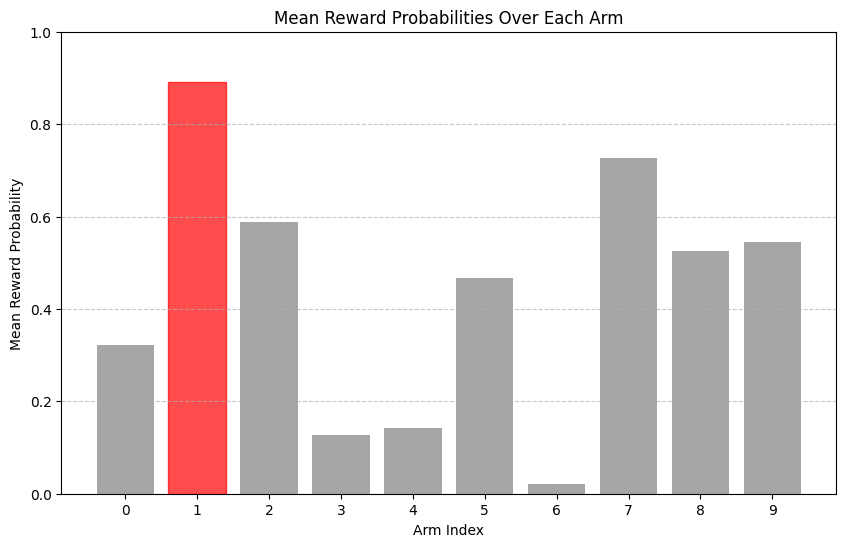

In [122]:
num_arms = 10
random_seed = 2023
np.random.seed(random_seed)

reward_probs = np.random.uniform(size=num_arms)

best_arm_idx = np.argmax(reward_probs)
print(f"Best arm index: {best_arm_idx} with probability {reward_probs[best_arm_idx]:.2f}")

mean_reward_prob = np.mean(reward_probs)
highest_acheivable_reward = np.max(reward_probs)
print(f"Mean reward probability across all arms: {mean_reward_prob:.2f}")

plt.figure(figsize=(10, 6))
plt.title("Mean Reward Probabilities Over Each Arm")
barlist =plt.bar(range(num_arms), reward_probs, color='gray', alpha=0.7)
barlist[best_arm_idx].set_color('red')
plt.xlabel("Arm Index")
plt.ylabel("Mean Reward Probability")
plt.xticks(range(num_arms))
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

### Random Exploration Bandit

In [128]:
class MultiArmedBandit:
    def __init__(self, num_arms, reward_probs):
        self.num_arms = num_arms
        self.reward_probs = reward_probs

    def run_iteration(self, iters, time_steps):
        reward_hists = []
        explored_cnts = []

        for t in range(iters):
            reward_hist, explored_cnt = self.run_episode(time_steps)
            reward_hists.append(reward_hist)
            explored_cnts.append(explored_cnt)
        
        # Compute average statistics over iterations
        avg_reward = np.mean(reward_hists, axis=0)
        std_reward = np.std(reward_hists, axis=0)
        avg_explored_cnt = np.mean(explored_cnts, axis=0)
        std_explored_cnt = np.std(explored_cnts, axis=0)
        return avg_reward, std_reward, avg_explored_cnt, std_explored_cnt
    
    def run_episode(self, time_steps):
        rewards = []
        exp_reward_prob = np.zeros(self.num_arms)
        explored_cnt = np.zeros(self.num_arms)

        for t in range(time_steps):
            arm, reward = self.step()
            exp_reward_prob, explored_cnt = self.update(arm, reward, exp_reward_prob, explored_cnt)
            rewards.append(reward)
        
        return np.array(rewards), explored_cnt

    def step(self):
        arm = np.random.randint(0, self.num_arms)
        reward = np.random.binomial(1, self.reward_probs[arm])
        return arm, reward

    def update(self, arm, reward, exp_reward_prob, explored_cnt):
        explored_cnt[arm] += 1
        exp_reward_prob[arm] = exp_reward_prob[arm] + (1/explored_cnt[arm] * (reward - exp_reward_prob[arm]))  # online update to sample mean
        return exp_reward_prob, explored_cnt

    def plot_algorithm_performance(self, algo, avg_reward_hist, std_reward_hist, avg_explored_cnt, time_steps, best_arm_prob, fontsize=15):
            # Create subplots to visualize algorithm performance metrics.
            plt.figure(figsize=(20,5))

            # Plot average reward over time steps.
            plt.subplot(1,3,1)
            plt.plot(list(range(time_steps)), avg_reward_hist, color='b')
            plt.axhline(y=best_arm_prob, color='r')
            plt.ylim([0, 1])
            plt.xlabel('Time steps', fontsize=fontsize)
            plt.ylabel('Avg. reward at each time step', fontsize=fontsize)

            # Plot average reward across all time steps.
            plt.subplot(1,3,2)
            avg_reward = [np.mean(avg_reward_hist), best_arm_prob]
            std_reward = [np.std(avg_reward_hist), 0]
            plt.bar([algo, 'Best'], avg_reward, yerr=std_reward, color='gray')
            plt.ylim([0, 1])
            plt.xticks(fontsize=fontsize)
            plt.ylabel('Avg. reward over time steps', fontsize=fontsize)

            # Plot average explored count for each arm.
            plt.subplot(1,3,3)
            arm_labels =  [str(x) for x in range(self.num_arms)]
            plt.bar(arm_labels, avg_explored_cnt, color='gray')
            plt.xticks(fontsize=fontsize)
            plt.ylabel('Avg. explored trial count', fontsize=fontsize)

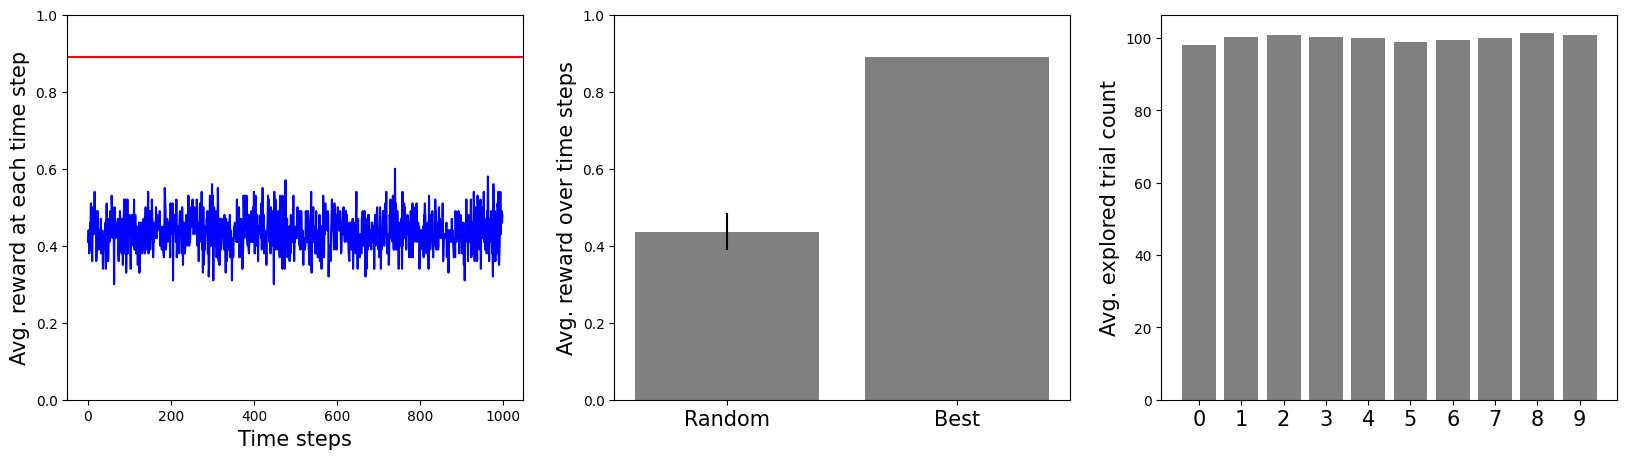

In [130]:
rand_bandit = MultiArmedBandit(num_arms, reward_probs)
iters = 100
time_steps = 1000
avg_reward, std_reward, avg_explored_cnt, std_explored_cnt = rand_bandit.run_iteration(iters, time_steps)
rand_bandit.plot_algorithm_performance('Random', avg_reward, std_reward, avg_explored_cnt, time_steps, reward_probs[best_arm_idx])

### $\epsilon$-greedy Bandit

In [131]:
class EpsilonGreedy(MultiArmedBandit):
    def __init__(self, num_arms, reward_probs, epsilon):
        super().__init__(num_arms, reward_probs)
        self.epsilon = epsilon
    
    def run_episode(self, time_steps):
        rewards = []
        exp_reward_prob = np.zeros(self.num_arms)
        explored_cnt = np.zeros(self.num_arms)

        for t in range(time_steps):
            arm, reward = self.step(exp_reward_prob)
            exp_reward_prob, explored_cnt = self.update(arm, reward, exp_reward_prob, explored_cnt)
            rewards.append(reward)
        
        return np.array(rewards), explored_cnt

    def step(self, exp_reward_prob):
        if np.random.rand() < self.epsilon:
            # Explore: choose a random arm
            arm = np.random.randint(0, self.num_arms)
        else:
            # Exploit: choose the best arm based on current estimates
            maxes = np.where(exp_reward_prob == np.max(exp_reward_prob))[0]  # this handles ties
            arm = np.random.choice(maxes)
        reward = np.random.binomial(1, self.reward_probs[arm])
        return arm, reward

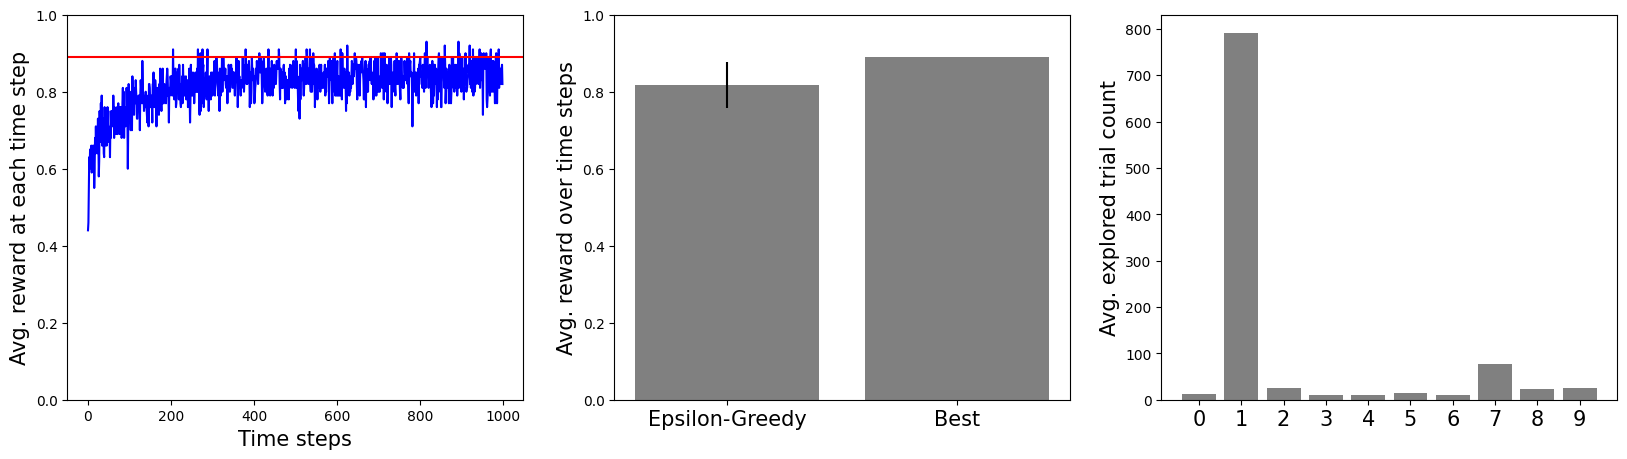

In [132]:
epsilon = 0.1
epsilon_bandit = EpsilonGreedy(num_arms, reward_probs, epsilon)
iters = 100
time_steps = 1000
avg_reward, std_reward, avg_explored_cnt, std_explored_cnt = epsilon_bandit.run_iteration(iters, time_steps)
epsilon_bandit.plot_algorithm_performance('Epsilon-Greedy', avg_reward, std_reward, avg_explored_cnt, time_steps, reward_probs[best_arm_idx])

#### Which $\epsilon$ to choose?
Simple grid search

Best average reward: 0.81721


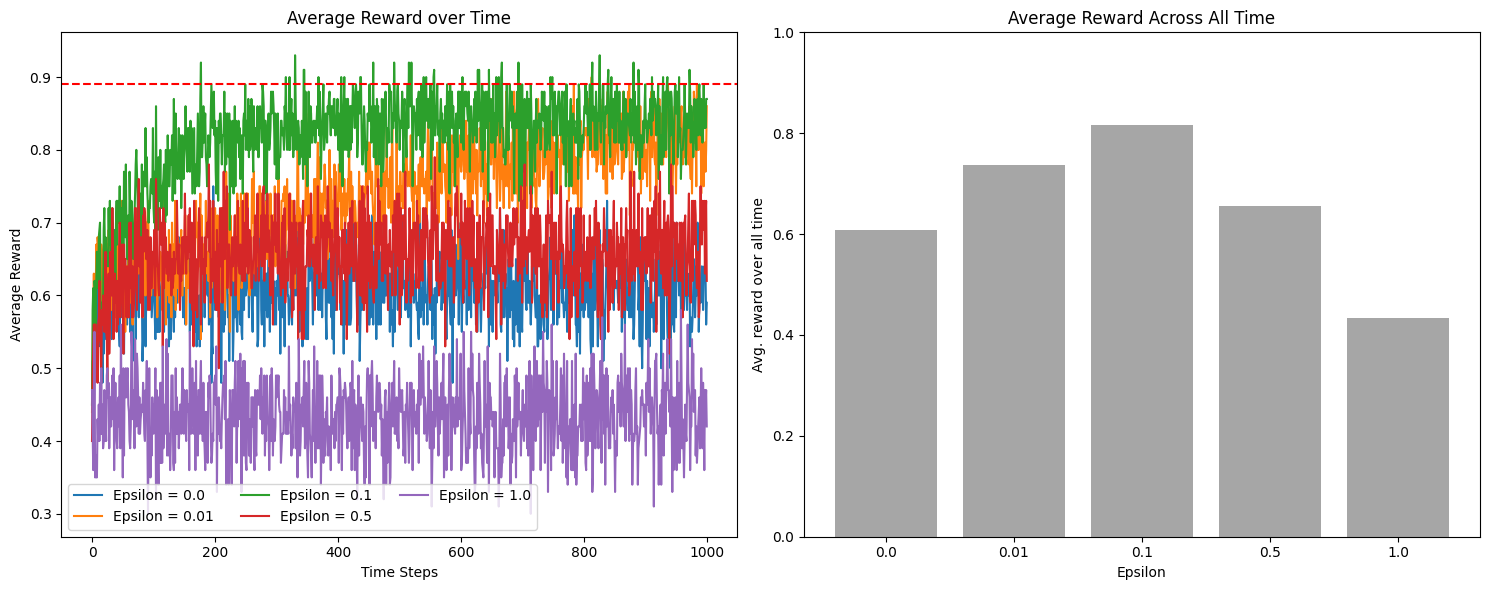

In [159]:
epsilons = [0., 0.01, 0.1, 0.5, 1.]
avg_rewards = []
for epsilon in epsilons:
    epsilon_bandit = EpsilonGreedy(num_arms, reward_probs, epsilon)
    iters = 100
    time_steps = 1000
    avg_reward, _, _, _ = epsilon_bandit.run_iteration(iters, time_steps)
    avg_rewards.append(avg_reward)

# Plot reward trajectories and average rewards for each epsilon
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Average Reward over Time")
for i, epsilon in enumerate(epsilons):
    plt.plot(avg_rewards[i], label=f'Epsilon = {epsilon}')
plt.axhline(highest_acheivable_reward, color='red', linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Average Reward")
plt.legend(ncol=3)

plt.subplot(1, 2, 2)
plt.title("Average Reward Across All Time")
avg_reward_all_time = [np.mean(reward_hist) for reward_hist in avg_rewards]
epsilons_str = [str(eps) for eps in epsilons]
plt.bar(epsilons_str, avg_reward_all_time, color='gray', alpha=0.7)
plt.ylim(0, 1)
plt.ylabel("Avg. reward over all time")
plt.xlabel('Epsilon')

print(f"Best average reward: {np.max(avg_reward_all_time)}")

plt.tight_layout()
plt.show()

### $\epsilon$-greedy with decay

In [148]:
class EpsilonDecreasing(MultiArmedBandit):
    def __init__(self, num_arms, reward_probs, epsilon, alpha):
        super().__init__(num_arms, reward_probs)
        self.epsilon = epsilon
        self.epsilon_update = epsilon  # decay this attribute
        self.alpha = alpha
    
    def run_episode(self, time_steps):
        rewards = []
        exp_reward_prob = np.zeros(self.num_arms)
        explored_cnt = np.zeros(self.num_arms)
        self.epsilon_update = self.epsilon  # init value for each episode

        for _ in range(time_steps):
            arm, reward = self.step(exp_reward_prob)
            exp_reward_prob, explored_cnt = self.update(arm, reward, exp_reward_prob, explored_cnt)
            rewards.append(reward)
        
        return rewards, explored_cnt

    def step(self, exp_reward_prob):
        if np.random.random() < self.epsilon_update:
            arm = np.random.randint(0, self.num_arms)
        else:
            maxes = np.where(exp_reward_prob == np.max(exp_reward_prob))[0]  # this handles ties
            arm = np.random.choice(maxes)
        
        reward = np.random.binomial(1, self.reward_probs[arm])
        self.epsilon_update *= self.alpha
        return arm, reward

Best parameter combo is $\epsilon = 0.5$, $\alpha = 0.99$ with average reward 0.846


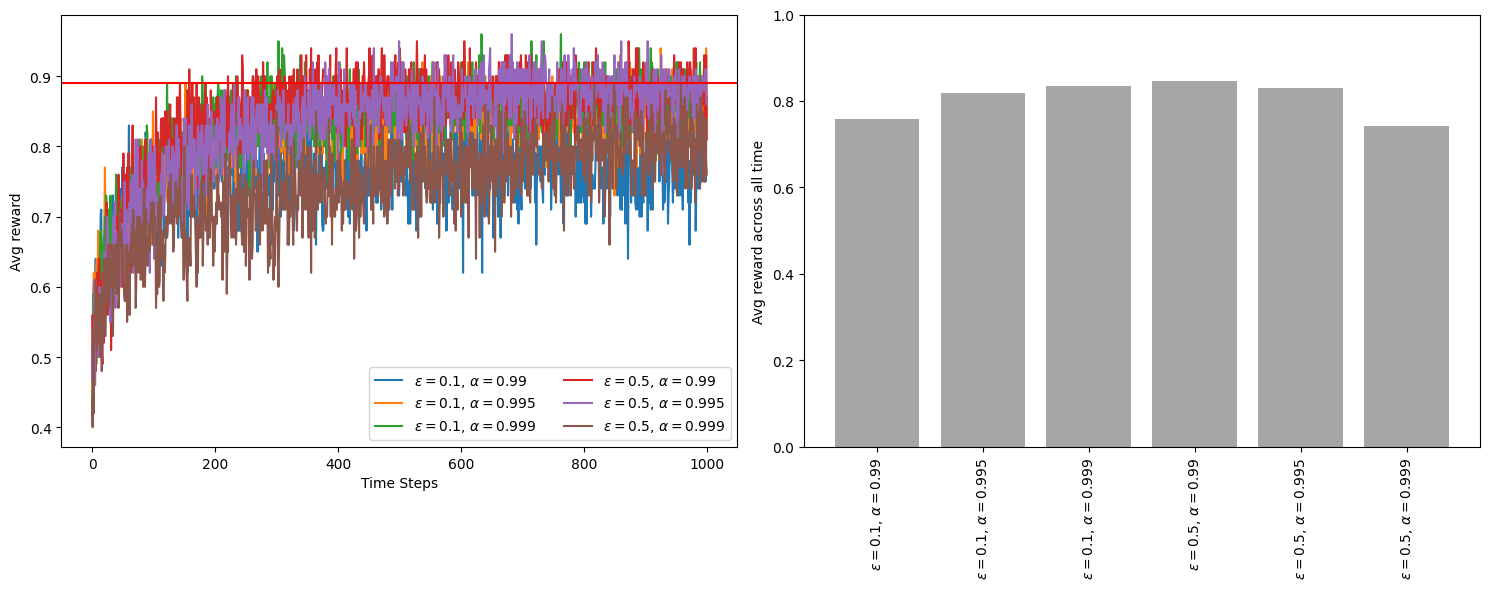

In [158]:
# grid searching to find the best combination of epsilon and alpha
epsilons = [0.1, 0.5]
alphas = [0.99, 0.995, 0.999]
avg_reward_hists = []
avg_reward_all_time = []

for epsilon in epsilons:
    for alpha in alphas:
        model = EpsilonDecreasing(num_arms, reward_probs, epsilon, alpha)
        avg_rewards, _, _, _ = model.run_iteration(iters, time_steps)
        avg_reward_hists.append(avg_rewards)
        avg_reward_all_time.append(np.mean(avg_rewards))
    
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
labels = []
plot_idx = 0
for i in range(len(epsilons)):
    for j in range(len(alphas)):
        l = fr"$\epsilon = {epsilons[i]}$, $\alpha = {alphas[j]}$"
        plt.plot(range(time_steps), avg_reward_hists[plot_idx], label=l)
        labels.append(l)
        plot_idx += 1

plt.legend(ncol=2)
plt.axhline(highest_acheivable_reward, color='r')
plt.xlabel('Time Steps')
plt.ylabel('Avg reward')

plt.subplot(1, 2, 2)
plt.bar(labels, avg_reward_all_time, color='gray', alpha=0.7)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.ylabel("Avg reward across all time")

best_combo_idx = np.argmax(avg_reward_all_time)
print(f"Best parameter combo is {labels[best_combo_idx]} with average reward {avg_reward_all_time[best_combo_idx]:.3f}")

plt.tight_layout()
plt.show()

### UCB

In [161]:
class UCB(MultiArmedBandit):
    def __init__(self, num_arms, reward_probs, c):
        super().__init__(num_arms, reward_probs)
        self.c = c
    
    def run_episode(self, time_steps):
        rewards = []
        exp_reward_prob = np.zeros(self.num_arms)
        explored_cnt = np.zeros(self.num_arms)

        for trial in range(time_steps):
            arm, reward = self.step(exp_reward_prob, explored_cnt, trial)
            exp_reward_prob, explored_cnt = self.update(arm, reward, exp_reward_prob, explored_cnt)
            rewards.append(reward)
        return rewards, explored_cnt

    def step(self, exp_reward_prob, explored_cnt, trial):
        if trial < self.num_arms:  # ensures that we explore each arm once
            arm = trial
        else:
            ucb = exp_reward_prob + self.c * np.sqrt(np.log(trial + 1) / explored_cnt)
            maxes = np.where(ucb == ucb.max())[0]
            arm = np.random.choice(maxes)
        reward = np.random.binomial(1, self.reward_probs[arm])
        return arm, reward

Best c is 0.5 with average reward 0.859


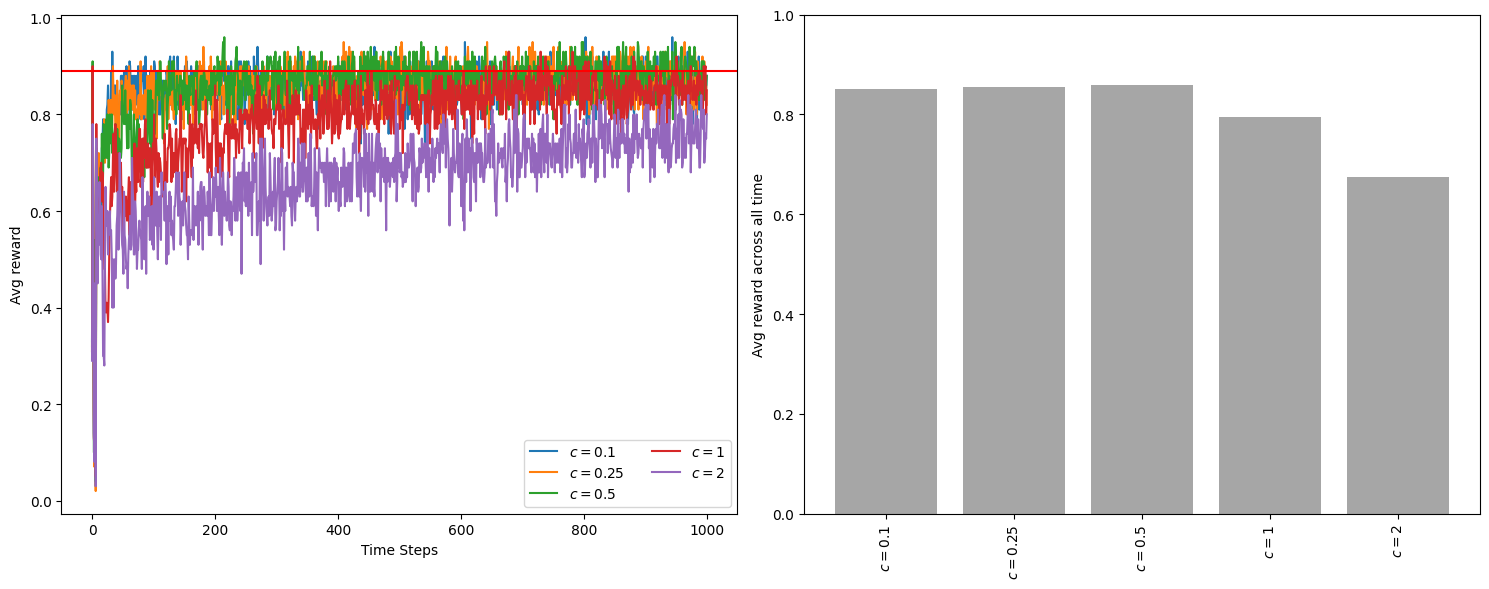

In [162]:
cs = [0.1, 0.25, 0.5, 1, 2]
avg_reward_hists = []
avg_reward_all_time = []

for c in cs:
    model = UCB(num_arms, reward_probs, c)
    avg_rewards, _, _, _ = model.run_iteration(iters, time_steps)
    avg_reward_hists.append(avg_rewards)
    avg_reward_all_time.append(np.mean(avg_rewards))

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
labels = []

for i in range(len(cs)):
    l = fr"$c = {cs[i]}$"
    plt.plot(range(time_steps), avg_reward_hists[i], label=l)
    labels.append(l)

plt.legend(ncol=2)
plt.axhline(highest_acheivable_reward, color='r')
plt.xlabel('Time Steps')
plt.ylabel('Avg reward')

plt.subplot(1, 2, 2)
plt.bar(labels, avg_reward_all_time, color='gray', alpha=0.7)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.ylabel("Avg reward across all time")

best_c = cs[np.argmax(avg_reward_all_time)]
print(f"Best c is {best_c} with average reward {np.max(avg_reward_all_time):.3f}")

plt.tight_layout()
plt.show()

### Thompson Sampling

In [165]:
class ThompsonSampling(MultiArmedBandit):
    def __init__(self, num_arms, reward_probs, prior=None):
        super().__init__(num_arms, reward_probs)
        self.prior = prior
    
    def run_episode(self, time_steps):
        rewards = []

        if self.prior is None:
            succ_fail = np.zeros((self.num_arms, 2))
        else:
            succ_fail = [x[:] for x in self.prior]  # deep copy
        
        explored_cnt = np.zeros(self.num_arms)

        for trial in range(time_steps):
            arm, reward = self.step(succ_fail, explored_cnt)
            succ_fail, explored_cnt = self.update(arm, reward, succ_fail, explored_cnt)
            rewards.append(reward)
        return rewards, explored_cnt

    def step(self, succ_fail, explored_cnt):
        samples = [np.random.beta(s + 1, f + 1) for s, f in succ_fail]
        arm = np.argmax(samples)
        reward = np.random.binomial(1, self.reward_probs[arm])
        return arm, reward
    
    def update(self, arm, reward, succ_fail, explored_cnt):
        explored_cnt[arm] += 1
        if reward == 0:
            succ_fail[arm][1] += 1
        elif reward == 1:
            succ_fail[arm][0] += 1
        
        return succ_fail, explored_cnt

Best prior is Prior 2 with average reward 0.891


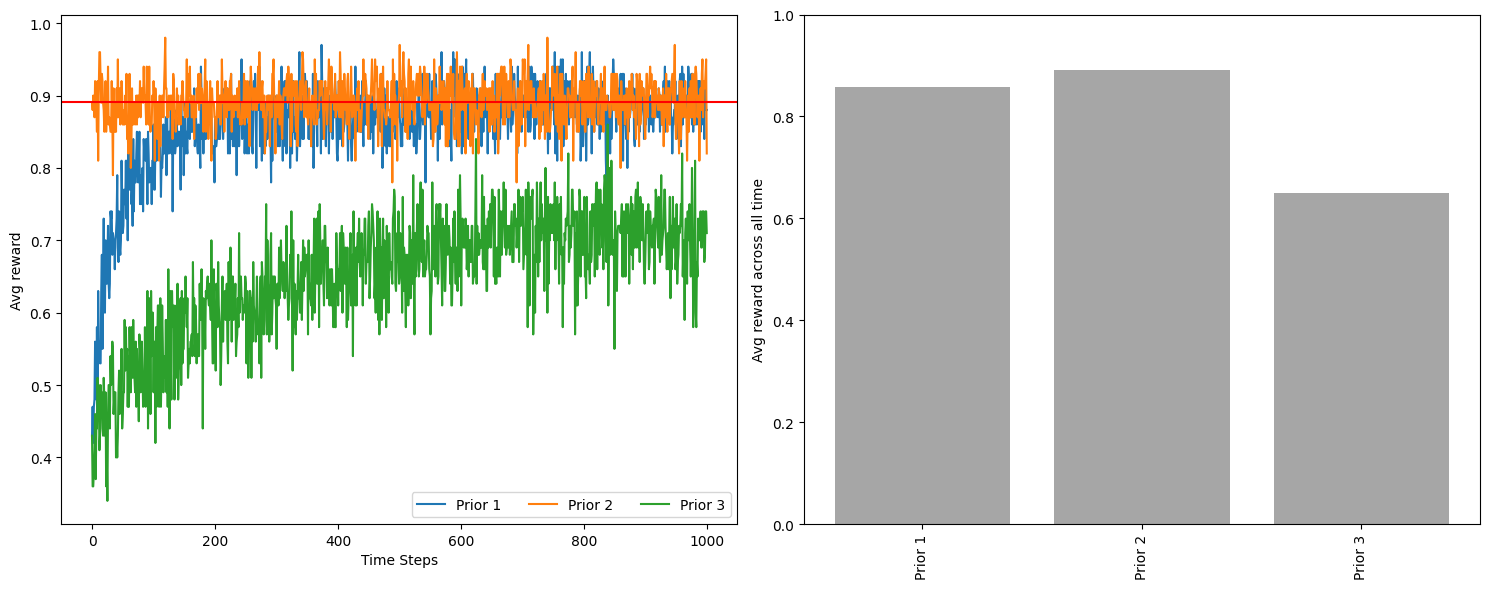

In [166]:
prior1 = None # Uniform proir
prior2 = [[1,10],[10,1],[1,10],[1,10],[1,10],[1,10],[1,10],[1,10],[1,10],[1,10]] # Good prior
prior3 = [[10,1],[1,10],[10,1],[10,1],[10,1],[10,1],[10,1],[10,1],[10,1],[10,1]] # Bad prior

priors = [prior1, prior2, prior3]
avg_reward_hists = []
avg_reward_all_time = []

for prior in priors:
    model = ThompsonSampling(num_arms, reward_probs, prior)
    avg_rewards, _, _, _ = model.run_iteration(iters, time_steps)
    avg_reward_hists.append(avg_rewards)
    avg_reward_all_time.append(np.mean(avg_rewards))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
labels = []

for i in range(len(priors)):
    l = f"Prior {i+1}"
    plt.plot(range(time_steps), avg_reward_hists[i], label=l)
    labels.append(l)

plt.legend(ncol=3)
plt.axhline(highest_acheivable_reward, color='r')
plt.xlabel('Time Steps')
plt.ylabel('Avg reward')

plt.subplot(1, 2, 2)
plt.bar(labels, avg_reward_all_time, color='gray', alpha=0.7)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.ylabel("Avg reward across all time")

best_prior_idx = np.argmax(avg_reward_all_time)
print(f"Best prior is {labels[best_prior_idx]} with average reward {avg_reward_all_time[best_prior_idx]:.3f}")

plt.tight_layout()
plt.show()